In [1]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [2]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive
# !pip install -q keras
# !pip install -q pandas
# !pip install -q numpy

In [3]:
# cp ~/.config/google-chrome/Default/Cookies ~/.config/google-chrome/Default/Cookies.bak
# cp ~/.config/google-chrome/Default/Cookies ~/.config/google-chrome/Default/Cookies.bak
import os 
import sys
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt

from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, Reshape, Flatten, MaxPooling1D, UpSampling1D
from keras.layers.recurrent import LSTM
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM
from keras.callbacks import History, ModelCheckpoint 

from iteration_utilities import flatten
from sklearn import model_selection
from __future__ import absolute_import

/home/anton/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# os.chdir("/content/drive/Hamming")
# sys.path.append("Hamming")

# import functions as f
# import model_lib 

In [5]:
tf.test.gpu_device_name()

''

# Set code params

In [6]:
# N, K_ = 31, 26
N, K_= 16, 11

In [7]:
# directory to save model, history, sub_datasets and pictures
model_directory = 'model_checkpoints_stratificate_2/'

In [8]:
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [9]:
TRAIN_PATH = './dataset_files/hamming_15_11.txt'
TEST_PATH = './dataset_files/hamming_15_11_all.txt'

COLUMN_NAMES = ['plainword', 'codeword', 
                'id_error', 'bin_error', 'defective_codeword']
types = [str, str, int, str, str]
types = dict(zip(COLUMN_NAMES, types))

# Define functions

In [10]:
def load_data(path):
    return pd.read_csv(path, sep=';', names=COLUMN_NAMES, dtype=types)

In [11]:
def hamming_distance(first: str, second: str) -> int:
    return len([1 for (x, y) in zip(first, second) if x != y])

In [12]:
def make_features():
#     data['dec_defective_codeword'] = data['defective_codeword'][:].apply(lambda x: int(x, 2))

    for j in range(len(data['codeword'][0])):
        data['cod_' + str(j)] = data['codeword'][:].apply(lambda x: int(x[j]))

    for j in range(len(data['defective_codeword'][0])):
        data['def_' + str(j)] = data['defective_codeword'][:].apply(lambda x: int(x[j]))

#     for j in range(len(data['bin_error'][0])):
#         data['mask_' + str(j)] = data['bin_error'][:].apply(lambda x: int(x[j]))
        
    data['weight'] = 1
    data.loc[data['codeword'] == data['defective_codeword'], 'weight'] = 10  ### 19
    for j in range(len(data['plainword'][0])):
        data['pln_' + str(j)] = data['plainword'][:].apply(lambda x: int(x[j]))
    
#     return data

In [13]:
def stratificate_split_data(test_size):
    N1 = N + 1
    to_test = round(N1 * test_size)  # count of lines from each "pack" 
    to_train = N1 - to_test

    train_indices = [list(range(i*N1, i*N1 + to_train)) for i in range(2**K_)]
    train_indices = list(flatten(train_indices))
    test_indices = sorted(set(range(N1 * 2**K_)) - set(train_indices))
    
    train_data = data.loc[train_indices, 'def_0':'weight']
    test_data = data.loc[test_indices, 'def_0':'weight']
    
    train_labels = data.loc[train_indices, 'cod_0':'cod_'+str(N-1)]
    test_labels = data.loc[test_indices, 'cod_0':'cod_'+str(N-1)]
    
    train_weight = train_data.pop('weight')
    test_data.drop(columns=['weight'], inplace=True)
    return np.array(train_data), np.array(test_data), \
           np.array(train_labels), np.array(test_labels), \
           np.array(train_weight)

In [14]:
def split_data(test_size): 
    train_data, test_data, train_labels, test_labels = \
        model_selection.train_test_split(data.loc[:, 'def_0':'weight'], 
                                         data.loc[:, 'cod_0':'cod_'+str(N-1)], # 'mask_0':'pln_25' 
                                         test_size = test_size) 
    
    train_weight = train_data.pop('weight')
    test_data.drop(columns=['weight'], inplace=True)
    return np.array(train_data), np.array(test_data), \
           np.array(train_labels), np.array(test_labels), \
           np.array(train_weight)

In [15]:
def logloss(y_true, y_pred): 
    return -K.log(1 - K.abs(y_true - y_pred))

In [16]:
def exploss(y_true, y_pred): 
    return K.exp(K.abs(y_true - y_pred)) - 1

In [17]:
def probs_to_labels(predicted_probs):
    return [int(x > 0.5) for x in predicted_probs]

In [18]:
def count_errors(y, y_pred):
    count = 0
    for i in range (0, N):
        labelBit = y[i]
        resultBit = y_pred[i]
        if labelBit != resultBit:
            count += 1
    return count

In [19]:
def get_error_stats(test_labels, y_pred):
    errorStats = {0: 0}
    for i in range(y_pred.shape[0]):
        resultArray = probs_to_labels(y_pred[i])
        errorNum = count_errors(test_labels[i], resultArray)
        if errorStats.get(errorNum) == None:
            errorStats[errorNum] = 0
        errorStats[errorNum] += 1
    return errorStats

In [20]:
def binary_accuracy(y, y_pred):
    return sum(1 if np.array_equal(a, probs_to_labels(b)) else 0 for (a,b) in zip(y, y_pred)) / y.shape[0]

In [21]:
def plot_history_fields(history, fields, save=False, plot_from=0, plot_to=-1):
    # num_dots_to_plot == -1  => plot all

    figsize_x = 20
    figsize_y = 10
    
    fontsize = 20
    
    if 'loss' in fields:
        # summarize history for loss
        plt.figure(figsize=(figsize_x, figsize_y))
        plt.title('Функция потерь модели', fontsize=fontsize)
        plt.plot(history['val_loss'][plot_from:plot_to])
        plt.plot(history['loss'][plot_from:plot_to])
        plt.ylabel('Функция потерь', fontsize=fontsize)
        plt.xlabel('Номер эпохи', fontsize=fontsize)
        plt.legend(['Валидация', 'Обучение'], loc='upper right', fontsize=fontsize, borderpad=2, labelspacing=1)
        if save:
            plt.savefig(model_directory + 'model_loss.png')
        plt.show()
        
    if 'accuracy' in fields:
        # summarize history for accuracy
        plt.figure(figsize=(figsize_x, figsize_y))
        plt.title('Точность модели', fontsize=fontsize)
        plt.plot(history['val_acc'][plot_from:plot_to])
        plt.plot(history['acc'][plot_from:plot_to])
        plt.ylabel('Точность', fontsize=fontsize)
        plt.xlabel('Номер эпохи', fontsize=fontsize)
        plt.legend(['Валидация', 'Обучение'], loc='lower right', fontsize=fontsize, borderpad=2, labelspacing=1)
        if save:
            plt.savefig(model_directory + 'model_accuracy.png')
        plt.show()
        
    if 'binary_accuracy' in fields:
        # summarize history for binary accuracy
        plt.figure(figsize=(figsize_x, figsize_y))
        plt.title('Бинарная точность модели', fontsize=fontsize)
        plt.plot(history['val_binary_accuracy'][plot_from:plot_to])
        plt.plot(history['binary_accuracy'][plot_from:plot_to])
        plt.ylabel('Бинарная точность', fontsize=fontsize)
        plt.xlabel('Номер эпохи', fontsize=fontsize)
        plt.legend(['Валидация', 'Обучение'], loc='lower right', fontsize=fontsize, borderpad=2, labelspacing=1)
        if save:
            plt.savefig(model_directory + 'model_binary_accuracy.png')
        plt.show()
        

In [22]:
# !git pull

# Load data and fit model

In [23]:
%%time
data = load_data(TEST_PATH)
print(data.shape)
make_features()
print(data.shape)
train_data, test_data, train_labels, test_labels, train_weight = stratificate_split_data(test_size=0.5)
# train_data, test_data, train_labels, test_labels, train_weight = split_data(test_size=0.3)
data.head()
# del(data)

(34816, 5)
(34816, 49)
CPU times: user 732 ms, sys: 10.7 ms, total: 743 ms
Wall time: 753 ms


In [24]:
# %%time
# data = load_data(TRAIN_PATH)
# # int_to_str()
# print(data.shape)
# make_features()
# print(data.shape)
# train_data, _, train_labels, _, train_weight = split_data(test_size=0.0001)

# data = load_data(TEST_PATH)
# # int_to_str()
# print(data.shape)
# make_features()
# print(data.shape)
# _, test_data, _, test_labels, _ = split_data(test_size=0.9999)
# del(data)

In [25]:
history = History()
MCP = ModelCheckpoint(model_directory + 'model_epoch:{epoch:02d}_val_loss:{val_loss:.4f}.hdf5', 
                      monitor='val_loss', 
                      verbose=0, 
                      save_best_only=True, 
                      save_weights_only=False, 
                      mode='auto', 
                      period=10
                     )

mul for N=16
* 10 - 84%
* 12 - 89%
* 13 - 92%
* 14 - 52%
* 15 - 7х%

In [26]:
mul = 1

In [26]:

# from keras import models
# from keras.utils import to_categorical
# from keras.callbacks import ModelCheckpoint

inp = Input(shape=(N,))
x = Dense(mul * N, activation='sigmoid')(inp)
# x = Dense(mul * N, activation='sigmoid', kernel_initializer = "glorot_uniform")(x)
# x = Dense(mul * N, activation='sigmoid', kernel_initializer = "glorot_uniform")(x)
# x = Dense(mul * N, activation='sigmoid', kernel_initializer = "glorot_uniform")(x)
m = Dense(N, activation='sigmoid', name='d3')(x)

model = Model(inp, m, 'm')
model.compile(loss=exploss, optimizer='adam', metrics=['binary_accuracy', 'accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
d3 (Dense)                   (None, 16)                272       
Total params: 544
Trainable params: 544
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.fit(x=train_data, y=train_labels, 
          validation_split=0.15,  
          shuffle=True, 
          epochs=4000, 
          batch_size=256, 
          callbacks=[history, MCP],
         )

Train on 15667 samples, validate on 2765 samples
Epoch 1/4000
15667/15667 [==============================] - 0s 22us/step - loss: 0.6491 - binary_accuracy: 0.5181 - acc: 0.0131 - val_loss: 0.6426 - val_binary_accuracy: 0.5345 - val_acc: 0.0163
Epoch 2/4000
15667/15667 [==============================] - 0s 6us/step - loss: 0.6334 - binary_accuracy: 0.5883 - acc: 0.0215 - val_loss: 0.6280 - val_binary_accuracy: 0.6247 - val_acc: 0.0203
Epoch 3/4000
15667/15667 [==============================] - 0s 6us/step - loss: 0.6195 - binary_accuracy: 0.6760 - acc: 0.0267 - val_loss: 0.6137 - val_binary_accuracy: 0.7033 - val_acc: 0.0297
Epoch 4/4000
15667/15667 [==============================] - 0s 6us/step - loss: 0.6048 - binary_accuracy: 0.7387 - acc: 0.0351 - val_loss: 0.5986 - val_binary_accuracy: 0.7506 - val_acc: 0.0354
Epoch 5/4000
15667/15667 [==============================] - 0s 6us/step - loss: 0.5892 - binary_accuracy: 0.7720 - acc: 0.0525 - val_loss: 0.5826 - val_binary_accuracy: 0.781

KeyboardInterrupt: 

# Check model accuracy

In [31]:
%%time
y_pred = model.predict(test_data)

CPU times: user 612 ms, sys: 26.2 ms, total: 638 ms
Wall time: 487 ms


In [32]:
get_error_stats(test_labels, y_pred)

{0: 15102, 1: 1264, 2: 17, 3: 1}

In [33]:
accuracy = binary_accuracy(test_labels, y_pred)
print(accuracy)

0.9217529296875


In [34]:
h = history.history

AttributeError: 'History' object has no attribute 'history'

### Plot and optionally save graphics

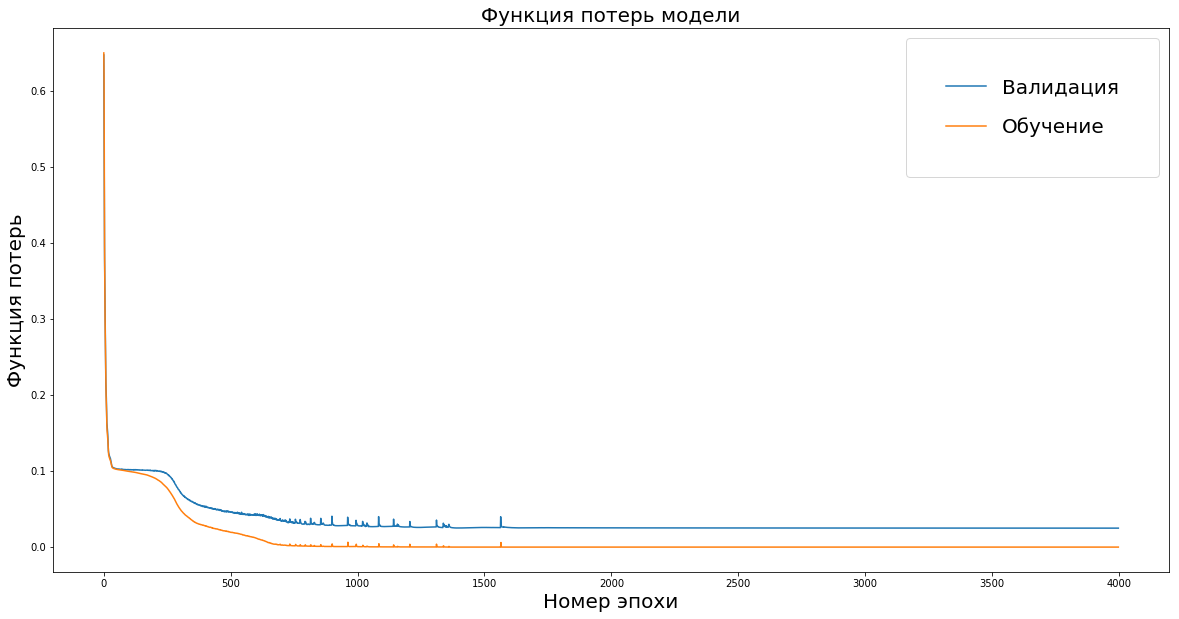

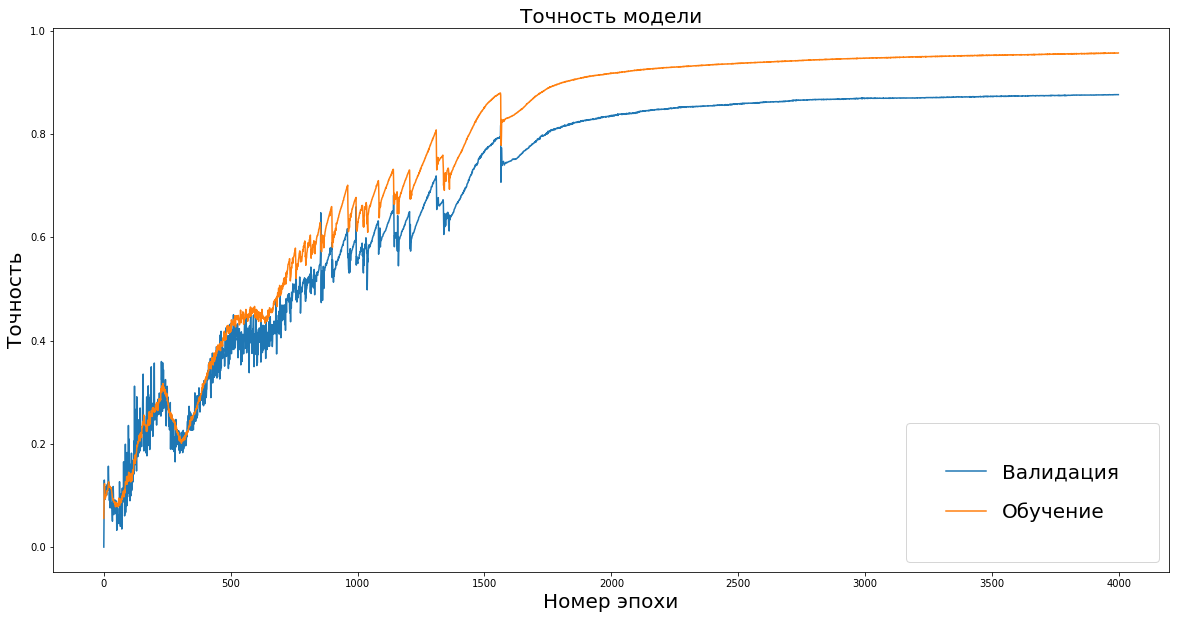

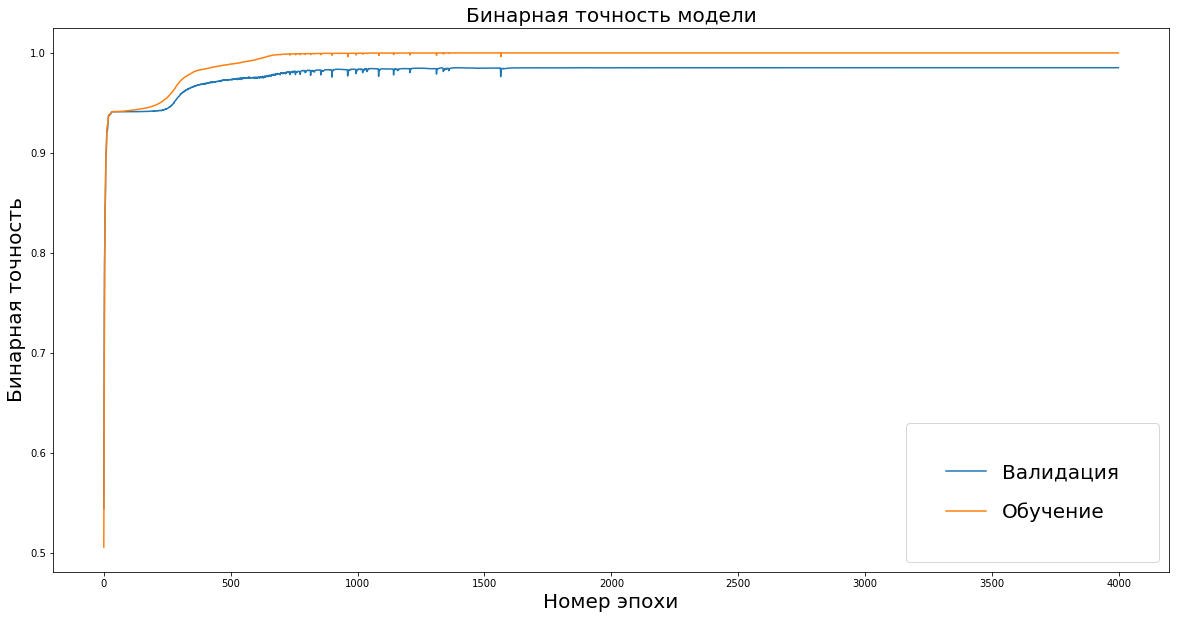

In [43]:
plot_history_fields(history=h, fields=['loss', 'accuracy', 'binary_accuracy'], 
#                     plot_from=1200, plot_to=2000, 
                    save=False)

In [ ]:
ac = np.array(h['val_acc'])
ac.argmax(), ac.max()

# Save data

In [ ]:
np.savetxt(model_directory + 'train_data.csv', train_data, delimiter=';')
np.savetxt(model_directory + 'test_data.csv', test_data, delimiter=';')
np.savetxt(model_directory + 'train_labels.csv', train_labels, delimiter=';')
np.savetxt(model_directory + 'test_labels.csv', test_labels, delimiter=';')

In [ ]:
json.dump(h, open(model_directory + 'history.json', 'w'))

In [27]:
file_name = model_directory + 'last_model.hdf5'

In [ ]:
model.save(file_name)

### Load data from file

In [28]:
file_name = model_directory + 'last_model.hdf5'

In [29]:
model = load_model(file_name, custom_objects={'exploss': exploss})

In [30]:
with open(model_directory + 'history.json') as f:
    h = json.load(f)

0. Сделать датасет поменьше
1. Поменять кодирующую матрицу Хэмминга (генерирующую - g.txt) -> Попробовать потренировать
2. Прочитать статью Бернштейна и оттуда перенять архитектуру


1. смотреть насколько маски ошибки отличаются от предикта
2. гиперпараметры (генеративная матрица, количество слоев, что предсказывается)
3. напомнить про ЛСТМ
4. попробовать GRU
5. добавлять 20 ошибо, а не в каждый бит (случайно)
6. генерить не первае 2**16, а рандомные слова